In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### TODO
- Fine tuning dei parametri
- Capire come salvare i dati [(documentazione)](https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html) 
- mapping delle probabilità da aggiungere alla rete.

In [6]:
#Change here if you want to use RGB images instead of grayscale
is_rgb=True
#Change here the size of the crop (original image is 424)
csize=324 


In [7]:
class GalaxyJungle(Dataset): # sarebbe interessante implementare un rescale/crop
    
    #the init function initializes the directory containing the image,
    #the annotations file,
    #and both transforms
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    #returns number of samples in the dataset
    def __len__(self):
        return (self.img_labels).shape[0]

    #loads a sample from the dataset
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        #retrieves the image
        image = Image.open(img_path)
        if not is_rgb: image = image.convert('L')
        #retrieves corresponding label
        label = self.img_labels.iloc[idx, 1:]
        #if possible, transform the image and the label into a tensor.
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label.values, dtype=torch.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, self.img_labels.iloc[idx, 0]

In [19]:
transfs = transforms.Compose([
    transforms.ToTensor(), #fa già la normalizzazione se l'immagine non è un tensore
    #transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]),  
    transforms.CenterCrop(csize)          #CROP
    ]) #transforms.compose per fare una pipe di transformazioni

DS = GalaxyJungle('../data/training/training_solutions_rev1.csv', '../data/training/', transfs)

tensor([0.3831, 0.6169, 0.0000, 0.0000, 0.6169, 0.0385, 0.5784, 0.4184, 0.1985,
        0.0000, 0.1048, 0.5121, 0.0000, 0.0545, 0.9455, 0.2015, 0.1817, 0.0000,
        0.0000, 0.0272, 0.0000, 0.0272, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2800, 0.1384, 0.0000, 0.0000, 0.0929, 0.0000, 0.0000, 0.0000,
        0.3255])
torch.Size([3, 324, 324])


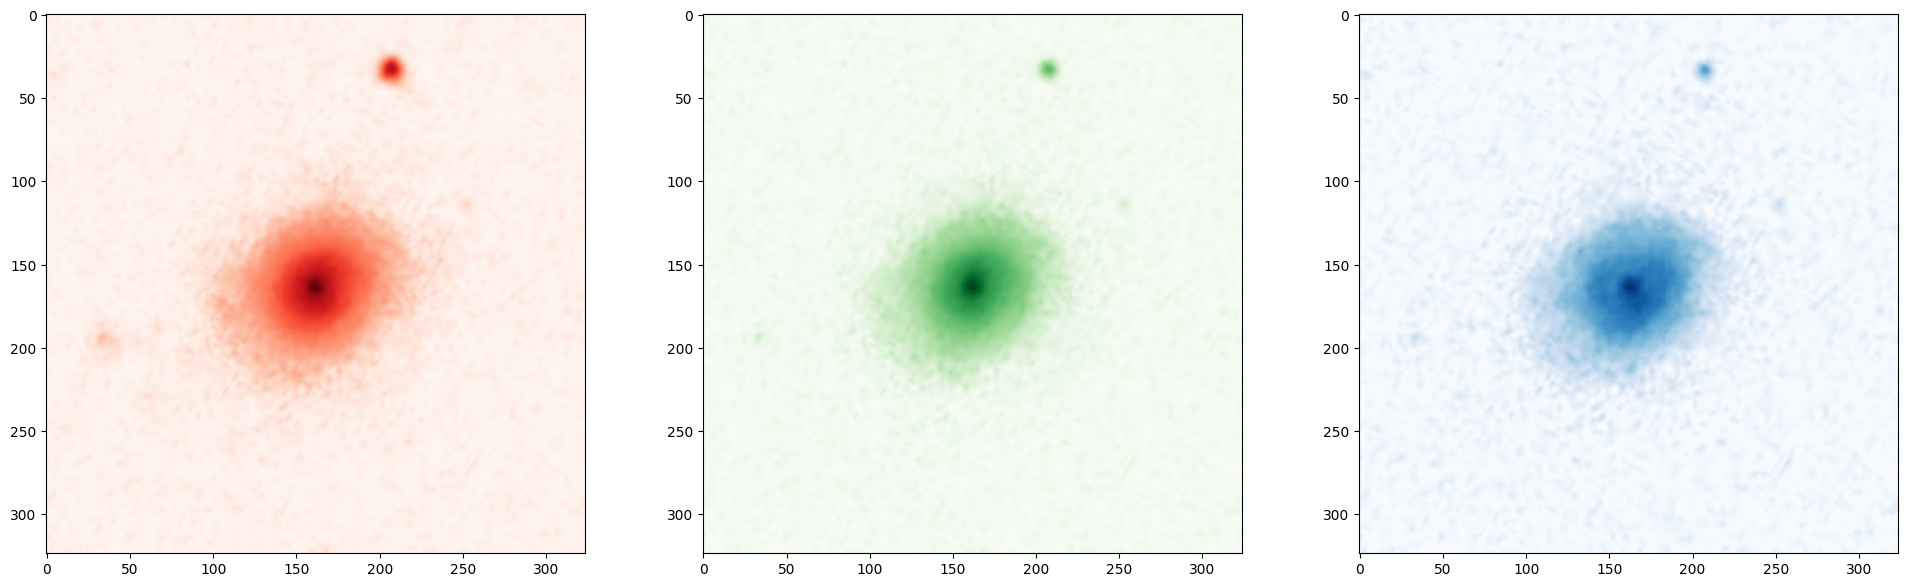

In [20]:
img, lab, indx = DS.__getitem__(0)
print(lab)
#print(img)         #3D TENSOR    
if is_rgb:
    fig, ax = plt.subplots(1,3, figsize=(24,7))
    color = ['Reds', 'Greens', 'Blues']
    for i,j in enumerate(img):
        ax[i].imshow(j, cmap=color[i])
else:
    fig, ax = plt.subplots(1,1, figsize=(24,7))
    ax.imshow(img[0], cmap='magma')
print(img.shape)


In [21]:
training, test = random_split(DS, [.8, .2])
train_loader = DataLoader(training, batch_size=128, shuffle=True, num_workers=8)
test_loader = DataLoader(test, batch_size=128, shuffle=False, num_workers=8)

## NET

In [22]:
#ENVIRONMENTAL VARIABLES
if is_rgb: in_channels=3
else: in_channels=1

#change here for fine tuning
kernel_size=5
out_channels=6
feature_map_2=16
max_pool_kernel=2

#for a 2 layer CNN:
size1=((csize-kernel_size)/1) + 1 #first convolution
size2=size1/max_pool_kernel       #first pooling
size3=((size2-kernel_size)/1)+1   #second convolution
size4=int(size3/max_pool_kernel)  #second pooling


In [23]:
class GalaxyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size) # convolutional layer # input 3 input channel, some output chans(feature maps) that are result from applying the kernel, also the kernel is trained during the process.
        ## Operation:  ((424-5)/1) +1 (6,420,420)
        self.pool = nn.MaxPool2d(max_pool_kernel,max_pool_kernel) #maxpool layer. divido per 2, -> (6,210,210)
        self.conv2 = nn.Conv2d(out_channels,feature_map_2,kernel_size) # 210-5 +1 = 206 -> (16,206,206) # dopo qui si fa di nuovo il pooling per cui si arriva a (16,103,103)
        self.fc1 = nn.Linear(feature_map_2*size4*size4,120) # fc è fully connected, #120 neuroni che prendono l'output
        self.fc2 = nn.Linear(120,84)# un altro fc layer che prende dai 120 neuroni e connette a 84 neuroni
        self.fc3 = nn.Linear(84,37)# idem sopra ma con 84 e 37 che è il numero di classi
        #i numeri non vincolati sono il primo 6 e il primo 16 e poi i numeri di neuroni
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # step 1 in cui c'è prima convoluzione e primo poool
        x = self.pool(F.relu(self.conv2(x))) # secondo step
        x = torch.flatten(x,1) # flatten operation -> 1 dimensional
        x = F.relu(self.fc1(x)) # apply relu al'output dei fully connected
        x = F.relu(self.fc2(x)) # idem sopra
        x = self.fc3(x) # output di fc3, 37 neuroni -> 37 classi ideally
        return x
    

gnet = GalaxyNet()
gnet.to(device)

GalaxyNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=97344, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=37, bias=True)
)

In [24]:
loss_function = nn.MSELoss()
optimizer = optim.SGD(gnet.parameters(), lr =0.001, momentum = 0.9)


In bianco e nero: 1 epoch 1m3s, loss 0.028

Colori: 1 epoch 1m37s, loss 0.029

In [25]:
for epoch in range(1):  # loop over the dataset multiple times
    print(f'Training epoch {epoch}')
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        #type(data)
        #print(data)
        inputs, labels, idx = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad() # set gradients to ZERO

        # forward + backward + optimize
        outputs = gnet(inputs) # whatever the net produces from inputs, at start completely wrong, then we compute loss 
        loss = loss_function(outputs, labels) # here we are! :) 
        loss.backward() # backpropagate the loss, 
        optimizer.step() # the nwe take a step using our optimizer

        # print statistics
        
        running_loss += loss.item()  ## idk
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

Training epoch 0


[1,    20] loss: 0.082
[1,    40] loss: 0.078
[1,    60] loss: 0.073
[1,    80] loss: 0.070
[1,   100] loss: 0.067
[1,   120] loss: 0.063
[1,   140] loss: 0.061
[1,   160] loss: 0.055
[1,   180] loss: 0.052
[1,   200] loss: 0.047
[1,   220] loss: 0.043
[1,   240] loss: 0.039
[1,   260] loss: 0.038
[1,   280] loss: 0.035
[1,   300] loss: 0.033
[1,   320] loss: 0.032
[1,   340] loss: 0.031
[1,   360] loss: 0.030
[1,   380] loss: 0.029
Finished Training


In [1]:
i=0

In [2]:
#explore our model parameter so we don't have to retrain if we want to use it again
i+=1
torch.save(gnet.state_dict(), 'gnet/trained_gnet_{i}.pth')

NameError: name 'torch' is not defined

In [ ]:
gnet = GalaxyNet()
gnet.load_state_dict(torch.load('gnet/trained_gnet_{i}.pth'))

<All keys matched successfully>

In [16]:
#Evaluation part

correct = 0
total = 0

gnet.eval()
with torch.no_grad():
    for i,data in enumerate(test_loader): ## da sostituire con il nostro test loader
        images, labels = data
        outputs = gnet(images)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0) # 424 instances???
        correct += (predicted == labels).sum().item()

accuracy = 100*correct/total
print(f'Accuracy : {accuracy}%')

ValueError: too many values to unpack (expected 2)

In [ ]:
new_transform = transforms.compose([
                                    transforms.Resize((424,424)),
                                    transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                     ])

def load_img(path):
    image = Image.open(path) # open image
    image = new_transform(image) # applies transforms
    image = image.unsqueeze(0) # we want to have a batch but just it the peculiar case of the video, 
    return image

paths = ['path1', 'path2']
images = [load_img(paths) for img in paths]

net.eval()
with torch.no_grad()
for image in images:
    output = net(image)
    _, predicted = torch.max(output,1)
    print('Prediction', class_names[predicted].item())